In [73]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions
#pd.options.display.max_rows

In [74]:
kp = pd.read_csv('/Users/caldavis/Documents/GitHub/Capstone-project/Data folder/KenPom Team Metrics.csv')
#kp.head(10)
kp_conf_rat = pd.read_csv('/Users/caldavis/Documents/GitHub/Capstone-project/Data folder/KP_Conf_Ratings.csv')
kp_conf_rat = kp_conf_rat[['Year_Conf', 'Conf_Abb', 'Conf_Rk', 'Conf_Full', 'Conf_Rating']]
kp_conf_rat.head(10)
kp.head(10)

,Season,TeamName,TeamName 2,Tempo,RankTempo,AdjTempo,RankAdjTempo,OE,RankOE,AdjOE,RankAdjOE,DE,RankDE,AdjDE,RankAdjDE,AdjEM,RankAdjEM,seed
0,2019,ABILENE CHRISTIAN,Abilene Christian,66.5681,293,66.0042,254,107.1020,87,103.6250,186,96.7466,43,101.5390,119,2.08626,145,15.0
1,2019,AIR FORCE,Air Force,67.2794,269,66.4070,234,98.7687,274,100.4310,250,105.6820,242,107.2750,238,-6.84432,241,NaN
2,2019,AKRON,Akron,68.4518,207,66.0150,253,99.4248,264,99.7930,257,94.0099,11,93.7022,21,6.09084,107,NaN
3,2019,ALABAMA,Alabama,69.8652,124,68.6333,115,102.4780,185,108.1130,100,102.2220,155,96.6354,50,11.47740,59,NaN
4,2019,ALABAMA A&M,Alabama A&M,67.5600,252,65.4905,282,88.7657,347,86.4818,350,104.8620,219,109.1420,265,-22.66000,344,NaN
5,2019,ALABAMA STATE,Alabama State,68.4214,210,67.0597,198,95.3075,322,94.5978,326,106.1970,250,110.9610,304,-16.36330,329,NaN
6,2019,ALBANY (NY),Albany (NY),66.3119,301,65.7351,268,99.2601,267,98.1540,283,103.2160,176,108.0060,250,-9.85221,277,NaN
7,2019,ALCORN STATE,Alcorn State,67.4020,260,65.6105,277,89.3041,346,88.7838,348,108.2200,288,113.4270,332,-24.64300,349,NaN
8,2019,AMERICAN,American,67.6929,247,66.4126,233,104.5920,141,101.7880,221,100.1360,104,104.9190,186,-3.13075,198,NaN
9,2019,APPALACHIAN STATE,Appalachian State,73.1875,27,71.4297,27,104.6920,138,105.9350,141,110.2310,315,109.5440,274,-3.60901,205,NaN


In [75]:
# All In One Go,

# Prep initial df,
d = pd.read_csv('/Users/caldavis/Documents/GitHub/Capstone-project/Data folder/final_data_by_player_type.csv')
d = pd.merge(d, kp, left_on=['Team', 'year'], right_on=['TeamName', 'Season'], how='left')
d = pd.merge(d, kp, left_on=['Team_n1', 'year'], right_on=['TeamName', 'Season'], how='left')
df = pd.merge(d, kp, left_on=['Team_n1', 'year_n1'], right_on=['TeamName', 'Season'], how='left')
df = pd.merge(df, kp_conf_rat, left_on=['conf_abbr', 'year'], right_on=['Conf_Abb', 'Year_Conf'], how='left')
df = pd.merge(df, kp_conf_rat, left_on=['conf_abbr_n1', 'year'], right_on=['Conf_Abb', 'Year_Conf'], how='left')
df = pd.merge(df, kp_conf_rat, left_on=['conf_abbr_n1', 'year_n1'], right_on=['Conf_Abb', 'Year_Conf'], how='left')
df = df.replace(to_replace='NO IDEA', value=0)
df = df.replace(to_replace='---', value=0)
df = df.fillna(0)

# Convert to Numeric,
df[['games', 'games_started', 'mp_per_g', 'fg_per_g', 'fga_per_g', 'fg_pct', 'fg2_per_g', 'fg2a_per_g', 'fg2_pct', 'fg3_per_g', 'fg3a_per_g', 'fg3_pct', 'ft_per_g', 'fta_per_g', 'ft_pct', 'orb_per_g', 'drb_per_g', 'trb_per_g', 'ast_per_g', 'stl_per_g', 'blk_per_g', 'tov_per_g', 'pf_per_g', 'pts_per_g', 'sos', 'mp', 'fg', 'fga', 'fg2', 'fg2a', 'fg2_pct.1', 'fg3', 'fg3a', 'ft', 'fta', 'orb', 'drb', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts', 
    'fg_per_min', 'fga_per_min', 'fg2_per_min', 'fg2a_per_min', 'fg3_per_min', 'fg3a_per_min', 'ft_per_min', 'fta_per_min', 'trb_per_min', 'ast_per_min', 'stl_per_min', 'blk_per_min', 'tov_per_min', 'pf_per_min', 'pts_per_min', 
    'fg_per_poss', 'fga_per_poss', 'fg2_per_poss', 'fg2a_per_poss', 'fg3_per_poss', 'fg3a_per_poss', 'ft_per_poss', 'fta_per_poss', 'trb_per_poss', 'ast_per_poss', 'stl_per_poss', 'blk_per_poss', 'tov_per_poss', 'pf_per_poss', 'pts_per_poss', 'off_rtg', 'def_rtg', 'per', 'ts_pct', 'efg_pct', 'fg3a_per_fga_pct', 'fta_per_fga_pct', 'pprod', 'orb_pct', 'drb_pct', 'trb_pct', 'ast_pct', 'stl_pct', 'blk_pct', 'tov_pct', 'usg_pct', 'ows', 'dws', 'ws', 'ws_per_40', 'obpm', 'dbpm', 'bpm', 'year', 'Ht', 'Wt', 'G', 'S', 'X.Min', 'ORtg', 'X.Poss', 'X.Shots', 'games_n1', 'games_started_n1', 'mp_per_g_n1', 'fg_per_g_n1', 'fga_per_g_n1', 'fg_pct_n1', 'fg2_per_g_n1', 'fg2a_per_g_n1', 'fg2_pct_n1', 'fg3_per_g_n1', 'fg3a_per_g_n1', 'fg3_pct_n1', 'ft_per_g_n1', 'fta_per_g_n1', 'ft_pct_n1', 'orb_per_g_n1', 'drb_per_g_n1', 'trb_per_g_n1', 'ast_per_g_n1', 'stl_per_g_n1', 'blk_per_g_n1', 'tov_per_g_n1', 'pf_per_g_n1', 'pts_per_g_n1', 'sos_n1', 'mp_n1', 'fg_n1', 'fga_n1', 'fg2_n1', 'fg2a_n1', 'fg2_pct.1_n1', 'fg3_n1', 'fg3a_n1', 'ft_n1', 'fta_n1', 'orb_n1', 'drb_n1', 'trb_n1', 'ast_n1', 'stl_n1', 'blk_n1', 'tov_n1', 'pf_n1', 'pts_n1', 'fg_per_min_n1', 'fga_per_min_n1', 'fg2_per_min_n1', 'fg2a_per_min_n1', 'fg3_per_min_n1', 'fg3a_per_min_n1', 'ft_per_min_n1', 'fta_per_min_n1', 'trb_per_min_n1', 'ast_per_min_n1', 'stl_per_min_n1', 'blk_per_min_n1', 'tov_per_min_n1', 'pf_per_min_n1', 'pts_per_min_n1', 'fg_per_poss_n1', 'fga_per_poss_n1', 'fg2_per_poss_n1', 'fg2a_per_poss_n1', 'fg3_per_poss_n1', 'fg3a_per_poss_n1', 'ft_per_poss_n1', 'fta_per_poss_n1', 'trb_per_poss_n1', 'ast_per_poss_n1', 'stl_per_poss_n1', 'blk_per_poss_n1', 'tov_per_poss_n1', 'pf_per_poss_n1', 'pts_per_poss_n1', 'off_rtg_n1', 'def_rtg_n1', 'per_n1', 'ts_pct_n1', 'efg_pct_n1', 'fg3a_per_fga_pct_n1', 'fta_per_fga_pct_n1', 'pprod_n1', 'orb_pct_n1', 'drb_pct_n1', 
    'trb_pct_n1', 'ast_pct_n1', 'stl_pct_n1', 'blk_pct_n1', 'tov_pct_n1', 'usg_pct_n1', 'ows_n1', 'dws_n1', 'ws_n1', 'ws_per_40_n1', 'obpm_n1', 'dbpm_n1', 'bpm_n1', 'year_n1', 'Ht_n1', 'Wt_n1', 'G_n1', 'S_n1', 'X.Min_n1', 'ORtg_n1', 'X.Poss_n1', 'X.Shots_n1']] = df[['games', 'games_started', 'mp_per_g', 'fg_per_g', 'fga_per_g', 'fg_pct', 'fg2_per_g', 'fg2a_per_g', 'fg2_pct', 'fg3_per_g', 'fg3a_per_g', 'fg3_pct', 'ft_per_g', 'fta_per_g', 'ft_pct', 'orb_per_g', 'drb_per_g', 'trb_per_g', 'ast_per_g', 'stl_per_g', 'blk_per_g', 'tov_per_g', 'pf_per_g', 'pts_per_g', 'sos', 'mp', 'fg', 'fga', 'fg2', 'fg2a', 'fg2_pct.1', 'fg3', 'fg3a', 'ft', 'fta', 'orb', 'drb', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts', 'fg_per_min', 'fga_per_min', 'fg2_per_min', 'fg2a_per_min', 'fg3_per_min', 'fg3a_per_min', 'ft_per_min', 'fta_per_min', 'trb_per_min', 'ast_per_min', 'stl_per_min', 'blk_per_min', 'tov_per_min', 'pf_per_min', 'pts_per_min', 'fg_per_poss', 'fga_per_poss', 'fg2_per_poss', 'fg2a_per_poss', 'fg3_per_poss', 'fg3a_per_poss', 'ft_per_poss', 'fta_per_poss', 'trb_per_poss', 'ast_per_poss', 'stl_per_poss', 'blk_per_poss', 'tov_per_poss', 'pf_per_poss', 'pts_per_poss', 'off_rtg', 'def_rtg', 'per', 'ts_pct', 'efg_pct', 'fg3a_per_fga_pct', 'fta_per_fga_pct', 'pprod', 'orb_pct', 'drb_pct', 'trb_pct', 'ast_pct', 'stl_pct', 'blk_pct', 'tov_pct', 'usg_pct', 'ows', 'dws', 'ws', 'ws_per_40', 'obpm', 'dbpm', 'bpm', 'year', 'Ht', 'Wt', 'G', 'S', 'X.Min', 'ORtg', 'X.Poss', 'X.Shots', 'games_n1', 'games_started_n1', 'mp_per_g_n1', 'fg_per_g_n1', 'fga_per_g_n1', 'fg_pct_n1', 'fg2_per_g_n1', 'fg2a_per_g_n1', 'fg2_pct_n1', 'fg3_per_g_n1', 'fg3a_per_g_n1', 'fg3_pct_n1', 'ft_per_g_n1', 'fta_per_g_n1', 'ft_pct_n1', 'orb_per_g_n1', 'drb_per_g_n1', 'trb_per_g_n1', 'ast_per_g_n1', 'stl_per_g_n1', 'blk_per_g_n1', 'tov_per_g_n1', 'pf_per_g_n1', 'pts_per_g_n1', 'sos_n1', 'mp_n1', 'fg_n1', 'fga_n1', 'fg2_n1', 'fg2a_n1', 'fg2_pct.1_n1', 'fg3_n1', 'fg3a_n1', 'ft_n1', 'fta_n1', 'orb_n1', 'drb_n1', 'trb_n1', 'ast_n1', 'stl_n1', 'blk_n1', 'tov_n1', 'pf_n1', 'pts_n1', 'fg_per_min_n1', 'fga_per_min_n1', 'fg2_per_min_n1', 'fg2a_per_min_n1', 'fg3_per_min_n1', 'fg3a_per_min_n1', 'ft_per_min_n1', 'fta_per_min_n1', 'trb_per_min_n1', 'ast_per_min_n1', 'stl_per_min_n1', 'blk_per_min_n1', 'tov_per_min_n1', 'pf_per_min_n1', 'pts_per_min_n1', 'fg_per_poss_n1', 'fga_per_poss_n1', 'fg2_per_poss_n1', 'fg2a_per_poss_n1', 'fg3_per_poss_n1', 'fg3a_per_poss_n1', 'ft_per_poss_n1', 'fta_per_poss_n1', 'trb_per_poss_n1', 'ast_per_poss_n1', 'stl_per_poss_n1', 'blk_per_poss_n1', 'tov_per_poss_n1', 'pf_per_poss_n1', 'pts_per_poss_n1', 'off_rtg_n1', 'def_rtg_n1', 'per_n1', 'ts_pct_n1', 'efg_pct_n1', 'fg3a_per_fga_pct_n1', 'fta_per_fga_pct_n1', 'pprod_n1', 'orb_pct_n1', 'drb_pct_n1', 'trb_pct_n1', 'ast_pct_n1', 'stl_pct_n1', 'blk_pct_n1', 'tov_pct_n1', 'usg_pct_n1', 'ows_n1', 'dws_n1', 'ws_n1', 'ws_per_40_n1', 'obpm_n1', 'dbpm_n1', 'bpm_n1', 'year_n1', 'Ht_n1', 'Wt_n1', 'G_n1', 'S_n1', 'X.Min_n1', 'ORtg_n1', 'X.Poss_n1', 'X.Shots_n1']].apply(pd.to_numeric, errors='ignore')

# Add Contributions,
conditions = [(df['X.Poss_n1']>=28.0), (df['X.Poss_n1']>=24.0), (df['X.Poss_n1']>=20.0), (df['X.Poss_n1']>=16),
            (df['X.Poss_n1']>=12.0), (df['X.Poss_n1']<12)]
                                       #& (df['X.Min_n1']>=10.0))],
#(df['X.Min_n1']<10),,
#values = ['Go-To Guy', 'Major Contributor', 'Significant Contributor', 'Role Players', 'Limited Role', 'Nearly Invisible', 'Bench Warmer'],
values = [0, 1, 2, 3, 4, 5]
df['Contribution_n1'] = np.select(conditions, values)

# Add Year in School KP,
year_cond = [(df['Yr_n1']=='Fr'), (df['Yr_n1']=='So'),
            (df['Yr_n1']=='Jr'), (df['Yr_n1']=='Sr')]
year_val = [1, 2, 3, 4]
df['Class'] = np.select(year_cond, year_val)

# Add Ht. Categories,
ht_cond = [(df['Ht']<=74), (df['Ht']>74) & (df['Ht']<=76), (df['Ht']>76) & (df['Ht']<=78),
   (df['Ht']>78) & (df['Ht']<=80), (df['Ht']>80)]

ht_val = [0, 1, 2, 3, 4]
df['Pos_Ht'] = np.select(ht_cond, ht_val)
#df[‘column’] =( df[‘column’] – df[‘column’].mean() ) / df[‘column’].std(),

    
# Additional Features + Model Prep,
# df = df.drop(df[(df['games']<=20) & (df['games_started']/df['games']>0.7)].index)
# df = df.drop(df[(df['games_n1']<=20) & (df['games_started_n1']/df['games_n1']>0.7)].index)
df = df.drop(df[(df['games']<=13) & (df['games_started']/df['games']>0.1)].index)
df = df.drop(df[(df['games_n1']<=13) & (df['games_started_n1']/df['games_n1']>0.1)].index)


df = df.drop(df.loc[((df['games']>39) & (df['year']==2023)) | ((df['games_n1']>39) & (df['year_n1']==2023)) | 
   ((df['games']>40) & (df['year']==2022)) | ((df['games_n1']>40) & (df['year_n1']==2022)) | 
   ((df['games']>33) & (df['year']==2021)) | ((df['games_n1']>33) & (df['year_n1']==2021)) | 
   ((df['games']>35) & (df['year']==2020)) | ((df['games_n1']>35) & (df['year_n1']==2020)) | 
   ((df['games']>40) & (df['year']==2019)) | ((df['games_n1']>40) & (df['year_n1']==2019)) |
   (df['year']==0)]['Player.Name'].index)
idx = df.groupby(['Team', 'year'])['games'].max()
a = pd.DataFrame(idx)
ab = a.reset_index()
ab.columns = ['Team_max', 'year_max', 'games_max']
df = pd.merge(df, ab, left_on=['Team', 'year'], right_on=['Team_max', 'year_max'], how='left')
idx2 = df.groupby(['Team_n1', 'year_n1'])['games_n1'].max()
a2 = pd.DataFrame(idx2)
ab2 = a2.reset_index()
ab2.columns = ['Team_max', 'year_max', 'games_max']
df = pd.merge(df, ab2, left_on=['Team_n1', 'year_n1'], right_on=['Team_max', 'year_max'], how='left')
df.columns
tt = df[['Player.Name', 'Team', 'year', 'games_max_x', 'Team_n1', 'year_n1', 'games_max_y', 'games_n1']]
tt[tt['Player.Name']=='tevin-mack-1']
# df = df.drop(df[(df['games']<=0.05*df['games_max_x'])].index)
# df = df.drop(df[(df['games_n1']<=0.05*df['games_max_y'])].index)
df = df.drop(df.loc[(df['games_max_x']<15)].index)
df = df.drop(df.loc[(df['games_max_y']<15)].index)

#df = df.drop(df.loc[(df['year']==2020) | (df['year_n1']==2020)].index)
df = df.drop(df[(df['X.Min_n1']<=10)].index)
df = df.drop(df[(df['X.Min']<=10)].index)
df['Year_dif'] = df['year_n1']-df['year']
df['Team_AdjEM_dif'] = df['AdjEM_y']-df['AdjEM_x']
df['KP_Rk_Dif'] = df['RankAdjEM_y']-df['RankAdjEM_x']
df['KP_Conf_Dif'] = df['Conf_Rating_y']-df['Conf_Rating_x']
df['Calc A'] = df['X.Min']*df['ws']
df['Calc A2'] = df['X.Min']*df['bpm']
df['Calc A3'] = df['X.Min']*df['ORtg']
df['Calc A2_n1'] = df['X.Min_n1']*df['bpm_n1']
df['Calc A_n1'] =df['X.Min_n1']*df['ws_n1']
df['Calc A3_n1'] = df['X.Min_n1']*df['ORtg_n1']
df['Calc B'] = (df['stl_per_poss']+df['blk_per_poss']+df['DR.'])*df['X.Min']
df['Calc B_n1'] = (df['stl_per_poss_n1']+df['blk_per_poss_n1']+df['DR._n1'])*df['X.Min_n1']
df['Calc C']=(df['off_rtg']-df['def_rtg'])*df['X.Min']
df['Calc C_n1']=(df['off_rtg_n1']-df['def_rtg_n1'])*df['X.Min_n1']
df['Calc Overall A'] = df['Calc A'] + df['Calc B']
df['Calc Overall A2'] = df['Calc A2'] + df['Calc B']
df['Calc Overall A3'] = df['Calc A3'] + df['Calc B']
df['Calc Overall A_n1'] = df['Calc A_n1'] + df['Calc B_n1']
df['Calc Overall A2_n1'] = df['Calc A2_n1'] + df['Calc B_n1']
df['Calc Overall A3_n1'] = df['Calc A3_n1'] + df['Calc B_n1']
    
    
# Calc_A_n1_cond = [(df['Calc A_n1']<=340), (df['Calc A_n1']>340) & (df['Calc A_n1']<=664), (df['Calc A_n1']>664) & (df['Calc A_n1']<=1010),,
#            (df['Calc A_n1']>1010) & (df['Calc A_n1']<=1415), (df['Calc A_n1']>1415)],

# Calc_A_n1_val = [0, 1, 2, 3, 4],
# df['Calc_A_Contr'] = np.select(Calc_A_n1_cond, Calc_A_n1_val),
column_to_test = 'Calc A2_n1'
# Calc_overall_n1_cond = [(df[column_to_test]<=(df[column_to_test].max()-df[column_to_test].min())/10+df[column_to_test].min()), ,
#                         (df[column_to_test]>(df[column_to_test].max()-df[column_to_test].min())/10+df[column_to_test].min()) & (df[column_to_test]<=(df[column_to_test].max()-df[column_to_test].min())/2+df[column_to_test].min()), ,
#                         (df[column_to_test]>(df[column_to_test].max()-df[column_to_test].min())/2+df[column_to_test].min()) & (df[column_to_test]<=8*(df[column_to_test].max()-df[column_to_test].min())/10+df[column_to_test].min()),,
#                         (df[column_to_test]>8*(df[column_to_test].max()-df[column_to_test].min())/10+df[column_to_test].min())],

                        # & (df[column_to_test]<=4*(df[column_to_test].max()-df[column_to_test].min())/6+df[column_to_test].min()), ,
                        #(df[column_to_test]>4*(df[column_to_test].max()-df[column_to_test].min())/6+df[column_to_test].min())],
Calc_overall_n1_cond = [(df[column_to_test]<=df[column_to_test].quantile(0.12)),
                        (df[column_to_test]>df[column_to_test].quantile(0.12)) & (df[column_to_test]<=df[column_to_test].quantile(0.4)),
                        (df[column_to_test]>df[column_to_test].quantile(0.4)) & (df[column_to_test]<=df[column_to_test].quantile(0.88)),
                        (df[column_to_test]>df[column_to_test].quantile(0.88))]
# Calc_overall_n1_cond = [(df[column_to_test]<=df[column_to_test].quantile(0.5)),
#                         (df[column_to_test]>df[column_to_test].quantile(0.5)) & (df[column_to_test]<=df[column_to_test].quantile(0.88)),
#                         (df[column_to_test]>df[column_to_test].quantile(0.88))]
#Calc_A_n1_val = [2, 1, 0]
Calc_A_n1_val = [3, 2, 1, 0]
df['Calc_Overall_n1_Contr'] = np.select(Calc_overall_n1_cond, Calc_A_n1_val)

/var/folders/cq/16hkxgp926d466c0g9jzx2900000gq/T/ipykernel_18100/3786040254.py:4: DtypeWarning: Columns (13,16,38,144,147,169) have mixed types. Specify dtype option on import or set low_memory=False.
  d = pd.read_csv('/Users/caldavis/Documents/GitHub/Capstone-project/Data folder/final_data_by_player_type.csv')
/var/folders/cq/16hkxgp926d466c0g9jzx2900000gq/T/ipykernel_18100/3786040254.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Contribution_n1'] = np.select(conditions, values)
/var/folders/cq/16hkxgp926d466c0g9jzx2900000gq/T/ipykernel_18100/3786040254.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once usi

In [76]:
#df[['Team', 'year', 'games_max']].sort_values('games_max')


In [77]:
from sklearn.preprocessing import StandardScaler
# feature1 = ['bpm', 'Calc A2', 'ws', 'dws', 'ows', 'Calc Overall', 'KP_Conf_Dif', 'X.Poss', 
#                    'Year_dif',  'Calc A', 'Calc B', 
#                  'DR.',  'Team_AdjEM_dif', 'player_type',
#                  'Class', 'player_type', 'Pos_Ht', 'Calc C', 'off_rtg', 'def_rtg', 'ORtg']
feature1 = ['games', 'games_started', 'mp_per_g', 'fg_per_g', 'fga_per_g', 'fg_pct', 'fg2_per_g', 'fg2a_per_g', 'fg2_pct', 'fg3_per_g', 'fg3a_per_g', 'fg3_pct', 'ft_per_g', 'fta_per_g', 'ft_pct', 'orb_per_g', 'drb_per_g', 'trb_per_g', 'ast_per_g', 'stl_per_g', 'blk_per_g', 'tov_per_g', 'pf_per_g', 'pts_per_g', 'sos', 'mp', 'fg', 'fga', 'fg2', 'fg2a', 'fg2_pct.1', 'fg3', 'fg3a', 'ft', 'fta', 'orb', 'drb', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts', 
    'fg_per_min', 'fga_per_min', 'fg2_per_min', 'fg2a_per_min', 'fg3_per_min', 'fg3a_per_min', 'ft_per_min', 'fta_per_min', 'trb_per_min', 'ast_per_min', 'stl_per_min', 'blk_per_min', 'tov_per_min', 'pf_per_min', 'pts_per_min', 
    'fg_per_poss', 'fga_per_poss', 'fg2_per_poss', 'fg2a_per_poss', 'fg3_per_poss', 'fg3a_per_poss', 'ft_per_poss', 'fta_per_poss', 'trb_per_poss', 'ast_per_poss', 'stl_per_poss', 'blk_per_poss', 'tov_per_poss', 'pf_per_poss', 'pts_per_poss', 'off_rtg', 'def_rtg', 'per', 'ts_pct', 'efg_pct', 'fg3a_per_fga_pct', 'fta_per_fga_pct', 'pprod', 'orb_pct', 'drb_pct', 'trb_pct', 'ast_pct', 'stl_pct', 'blk_pct', 'tov_pct', 'usg_pct', 'ows', 'dws', 'ws', 'ws_per_40', 'obpm', 'dbpm', 'bpm', 'year', 'Ht', 'Wt', 'G', 'S', 'X.Min', 'ORtg', 'X.Poss', 'X.Shots']
# , 'X.Min', 'obpm', 'dbpm
# , 'Calc_Overall_n1_Contr'
y_try = df[['Calc_Overall_n1_Contr']]
#y_try = df[['Contribution_n1']]
df_temp = df
#print(df_temp.columns)
df_temp = df_temp.drop(['Calc_Overall_n1_Contr'], axis=1)
#df_temp = df_temp.drop(['Contribution_n1'], axis=1)
x_try = df_temp.loc[:, feature1].values
#y_try = df.loc[:,['target']].values

x_try = StandardScaler().fit_transform(x_try)

from sklearn.decomposition import PCA

pca = PCA(n_components=0.9, whiten=True)

principalComponents = pca.fit_transform(x_try)

principalDf = pd.DataFrame(data = principalComponents)
#principalDf = pd.concat([principalDf, df_temp['player_type']], axis=1)
principalDf.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-0.399736,-1.502383,0.839526,-1.105068,-0.610530,-0.514915,0.588737,-0.857263,0.665303,-0.373654,0.494884,0.632966,-0.107712,-0.260950,0.955123
1,0.391244,0.001832,1.992024,-0.282919,-0.271884,-0.290418,0.587469,1.048877,0.886420,0.006091,0.844398,-0.261904,-1.106423,0.103354,-1.365395
2,1.765332,0.405434,0.816671,-0.525012,0.448475,-0.195652,0.248336,0.480129,-0.161111,0.131852,0.395168,-1.235867,0.589824,0.946006,-0.947580
3,-0.817673,-0.948656,0.483373,1.479905,-0.133108,0.243053,-1.351586,0.809933,0.587677,-1.059694,-0.901187,0.748241,1.389988,0.191361,0.870353
4,-0.326003,-1.104752,1.707547,0.855847,-0.116153,0.063176,-1.162426,-0.563063,-0.377367,0.435705,-0.098298,-0.591568,-0.473398,-1.068280,0.882379
5,-0.563224,1.008921,1.781087,-1.980821,0.355911,-1.162320,1.909239,0.408937,-0.825454,-0.932700,-0.635280,-1.206155,-0.928331,1.125999,0.604389
6,-0.775943,1.386366,1.741951,-0.270622,0.769672,-0.378033,-1.570030,0.581449,-0.530963,-1.441110,0.341951,0.087120,-0.569550,-0.146766,-0.116241
7,-0.379358,-0.735516,-0.777769,0.944356,-0.494870,-0.215752,0.023973,-2.004329,0.496657,0.035018,0.541937,0.461108,-1.161814,-0.141790,1.472606
8,0.037532,-1.176900,-1.125246,1.139800,0.204508,-0.399068,0.336516,-2.005173,-0.162742,1.055527,0.756775,0.327493,-0.823606,0.633449,1.500249
9,0.124129,-1.109364,-2.204417,1.084159,-0.089643,-0.048892,0.586819,-2.017564,-0.564779,1.657073,-0.519432,2.042991,0.774850,0.677105,0.094303


In [78]:
# loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PCA10'], index=feature1)
# pd.set_option('display.max_rows', None)
# loadings

In [79]:
df['Calc A2_n1'].quantile(0.83)

262.09999999999985

array([[<Axes: title={'center': 'Calc A2_n1'}>]], dtype=object)

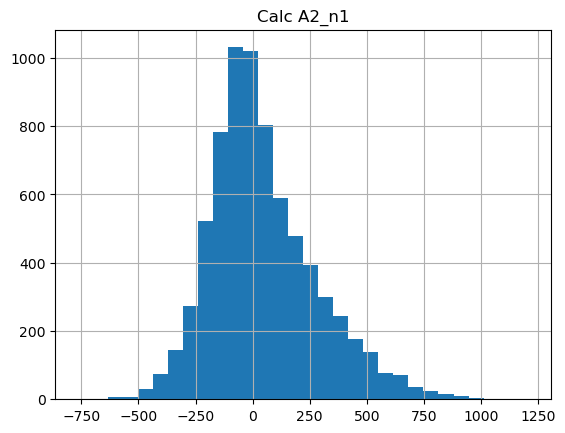

In [80]:
df.hist('Calc A2_n1', bins=30)

In [81]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import neighbors
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier


#df_test1 = principalDf - This one
df_test1 = df[['bpm', 'Calc A2', 'ws', 'dws', 'ows', 'Calc Overall A', 'Calc Overall A2', 'Calc Overall A3',
                 'KP_Conf_Dif', 'X.Poss', 'Year_dif',  'Calc A', 'Calc B', 
                 'DR.',  'Team_AdjEM_dif', 'player_type',
                 'Class', 'Pos_Ht', 'Calc C', 'off_rtg', 'def_rtg', 'ORtg', 'X.Min', 'obpm', 'dbpm', 
                 'Contribution_n1', 'Calc_Overall_n1_Contr', 'fg_per_poss', 'fga_per_poss', 'fg2_per_poss', 
                 'fg2a_per_poss', 'fg3_per_poss', 'fg3a_per_poss', 'ft_per_poss', 'fta_per_poss', 'trb_per_poss', 
                 'ast_per_poss', 'stl_per_poss', 'blk_per_poss', 'tov_per_poss', 'pf_per_poss', 'pts_per_poss', 
                 'per', 'ts_pct', 'efg_pct', 'fg3a_per_fga_pct', 'fta_per_fga_pct', 'pprod', 'orb_pct', 
                 'trb_pct', 'ast_pct', 'stl_pct', 'blk_pct', 'tov_pct', 'usg_pct', 'ws_per_40', 
                 'obpm', 'dbpm',  'Ht', 'Wt', 'G', 'S', 'X.Shots']]
# 'games', 'games_started', 'Calc A', 'Calc B', 'ast_per_poss', 'pts_per_poss', 'Ht', 'Wt', 'stl_per_poss', 'blk_per_poss', , ,
#df_test1 = df_test1[df_test1['player_type']==0],
# 'Calc Overall', 'Calc_Overall_Contr',
#'player_type', 'KP_Rk_Dif', 'ORtg', 'X.Min',,
#'Team_AdjEM_dif', 'X.Min_n1', 'X.Poss_n1',,
#df_test1 = df_test1[df_test1['player_type']==0],
columns = list(df_test1.columns)
columns.remove('Contribution_n1')

#columns.remove('Calc_Overall_Contr'),
columns.remove('Calc_Overall_n1_Contr')
columns.remove('player_type')
#columns.remove('Calc A2')
#,
keep_col = ['player_type'] #- This one
#keep_col = []
rem_columns = columns
check = True
accuracy_end = 0
while len(rem_columns)>0 and check == True:
    acc_check = 0

    for col in rem_columns:
        X = df_test1[keep_col + [col]]
    # X = df_test1[['player_type', 'X.Poss', 'X.Min', 'X.Min_n1', 'ORtg', ,
    #                       'Year_dif', 'stl_per_poss', 'blk_per_poss', ,
    #                       'DR.', 'KP_Rk_Dif', 'Calc A']],
        #y = df_test1[['Contribution_n1']],
        y = df_test1[['Calc_Overall_n1_Contr']]
        #y = y_try
        #y = df_test1[['Contribution_n1']],
        # Model,
        seed = 7
        test_size = 0.15
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
        # Random Forrest
        # model = RandomForestClassifier()
        # model.fit(X_train, y_train)

        # Naive-Bayes
        # model = GaussianNB()
        # model.fit(X_train, y_train)

        # Nearest Neighbors
        # model = neighbors.KNeighborsClassifier()
        # model.fit(X_train, y_train)

        # Support Vector Machine
        # model = svm.SVC(kernel='linear')
        # model.fit(X_train, y_train)
        
        # Gradient Boosting Classifier
        model = GradientBoostingClassifier()
        model.fit(X_train, y_train)
    
        # Find Accuracy,
        accuracy = model.score(X_test, y_test)
        # y_pred = model.predict(X_test),
        # predictions = [round(value) for value in y_pred],
        # accuracy = accuracy_score(y_test, predictions),
        print(keep_col + [col])
        print('Accuracy: ', accuracy * 100)
        if accuracy > acc_check:
            acc_check = accuracy
            col_to_add = col
            check = True
    #print(\Adding: \, col_to_add),
    
    #print(\Rem Columns: \, rem_columns),
    #keep_col = keep_col + [col_to_add],
    if accuracy_end < acc_check:
        print('Adding: ', col_to_add)
        print('Rem Columns: ', rem_columns)
        accuracy_end = acc_check
        print('Accuracy: ', accuracy_end * 100)
        rem_columns.remove(col_to_add)
        keep_col = keep_col + [col_to_add]
    else:
        print('Fails', accuracy_end, acc_check)
        check = False
    print(keep_col)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'bpm']
Accuracy:  53.669724770642205


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2']
Accuracy:  54.49541284403669


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'ws']
Accuracy:  48.25688073394495


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'dws']
Accuracy:  48.1651376146789


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'ows']
Accuracy:  46.60550458715596


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc Overall A']
Accuracy:  44.77064220183487


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc Overall A2']
Accuracy:  51.37614678899083


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc Overall A3']
Accuracy:  45.596330275229356


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'KP_Conf_Dif']
Accuracy:  44.77064220183487


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'X.Poss']
Accuracy:  46.14678899082569


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Year_dif']
Accuracy:  45.596330275229356


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A']
Accuracy:  47.79816513761468


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc B']
Accuracy:  45.96330275229358


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'DR.']
Accuracy:  46.51376146788991


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Team_AdjEM_dif']
Accuracy:  44.12844036697248


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Class']
Accuracy:  45.87155963302752


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Pos_Ht']
Accuracy:  45.87155963302752


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc C']
Accuracy:  47.981651376146786


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'off_rtg']
Accuracy:  47.24770642201835


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'def_rtg']
Accuracy:  46.972477064220186


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'ORtg']
Accuracy:  46.055045871559635


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'X.Min']
Accuracy:  44.4954128440367


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'obpm']
Accuracy:  49.63302752293578


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'dbpm']
Accuracy:  49.174311926605505


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'fg_per_poss']
Accuracy:  47.1559633027523


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'fga_per_poss']
Accuracy:  44.403669724770644


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'fg2_per_poss']
Accuracy:  45.04587155963303


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'fg2a_per_poss']
Accuracy:  45.77981651376147


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'fg3_per_poss']
Accuracy:  45.87155963302752


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'fg3a_per_poss']
Accuracy:  45.77981651376147


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'ft_per_poss']
Accuracy:  45.596330275229356


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'fta_per_poss']
Accuracy:  45.321100917431195


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'trb_per_poss']
Accuracy:  46.42201834862386


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'ast_per_poss']
Accuracy:  46.055045871559635


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'stl_per_poss']
Accuracy:  45.412844036697244


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'blk_per_poss']
Accuracy:  45.50458715596331


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'tov_per_poss']
Accuracy:  45.96330275229358


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'pf_per_poss']
Accuracy:  45.50458715596331


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'pts_per_poss']
Accuracy:  46.14678899082569


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'per']
Accuracy:  47.1559633027523


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'ts_pct']
Accuracy:  45.596330275229356


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'efg_pct']
Accuracy:  45.596330275229356


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'fg3a_per_fga_pct']
Accuracy:  46.60550458715596


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'fta_per_fga_pct']
Accuracy:  45.77981651376147


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'pprod']
Accuracy:  45.596330275229356


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'orb_pct']
Accuracy:  44.95412844036697


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'trb_pct']
Accuracy:  45.96330275229358


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'ast_pct']
Accuracy:  45.96330275229358


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'stl_pct']
Accuracy:  45.321100917431195


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'blk_pct']
Accuracy:  46.42201834862386


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'tov_pct']
Accuracy:  45.68807339449542


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'usg_pct']
Accuracy:  44.587155963302756


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'ws_per_40']
Accuracy:  46.972477064220186


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'obpm']
Accuracy:  49.63302752293578


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'dbpm']
Accuracy:  49.174311926605505


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Ht']
Accuracy:  45.87155963302752


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Wt']
Accuracy:  44.95412844036697


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'G']
Accuracy:  46.330275229357795


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'S']
Accuracy:  45.04587155963303


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'X.Shots']
Accuracy:  45.04587155963303
Adding:  Calc A2
Rem Columns:  ['bpm', 'Calc A2', 'ws', 'dws', 'ows', 'Calc Overall A', 'Calc Overall A2', 'Calc Overall A3', 'KP_Conf_Dif', 'X.Poss', 'Year_dif', 'Calc A', 'Calc B', 'DR.', 'Team_AdjEM_dif', 'Class', 'Pos_Ht', 'Calc C', 'off_rtg', 'def_rtg', 'ORtg', 'X.Min', 'obpm', 'dbpm', 'fg_per_poss', 'fga_per_poss', 'fg2_per_poss', 'fg2a_per_poss', 'fg3_per_poss', 'fg3a_per_poss', 'ft_per_poss', 'fta_per_poss', 'trb_per_poss', 'ast_per_poss', 'stl_per_poss', 'blk_per_poss', 'tov_per_poss', 'pf_per_poss', 'pts_per_poss', 'per', 'ts_pct', 'efg_pct', 'fg3a_per_fga_pct', 'fta_per_fga_pct', 'pprod', 'orb_pct', 'trb_pct', 'ast_pct', 'stl_pct', 'blk_pct', 'tov_pct', 'usg_pct', 'ws_per_40', 'obpm', 'dbpm', 'Ht', 'Wt', 'G', 'S', 'X.Shots']
Accuracy:  54.49541284403669
['player_type', 'Calc A2']


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'bpm']
Accuracy:  54.12844036697248


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ws']
Accuracy:  56.42201834862385


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'dws']
Accuracy:  55.41284403669725


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ows']
Accuracy:  56.23853211009175


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A']
Accuracy:  56.60550458715596


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A2']
Accuracy:  56.330275229357795


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A3']
Accuracy:  55.688073394495405


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'KP_Conf_Dif']
Accuracy:  54.403669724770644


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'X.Poss']
Accuracy:  54.58715596330275


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Year_dif']
Accuracy:  54.58715596330275


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc A']
Accuracy:  56.42201834862385


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc B']
Accuracy:  56.14678899082569


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'DR.']
Accuracy:  54.862385321100916


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Team_AdjEM_dif']
Accuracy:  56.14678899082569


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Class']
Accuracy:  55.41284403669725


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Pos_Ht']
Accuracy:  54.58715596330275


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc C']
Accuracy:  55.5045871559633


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg']
Accuracy:  55.04587155963303


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'def_rtg']
Accuracy:  55.779816513761475


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg']
Accuracy:  55.22935779816513


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'X.Min']
Accuracy:  55.96330275229357


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'obpm']
Accuracy:  54.862385321100916


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'dbpm']
Accuracy:  55.596330275229356


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'fg_per_poss']
Accuracy:  54.58715596330275


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'fga_per_poss']
Accuracy:  54.03669724770642


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'fg2_per_poss']
Accuracy:  54.67889908256881


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'fg2a_per_poss']
Accuracy:  55.688073394495405


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'fg3_per_poss']
Accuracy:  53.669724770642205


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'fg3a_per_poss']
Accuracy:  54.03669724770642


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ft_per_poss']
Accuracy:  55.688073394495405


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'fta_per_poss']
Accuracy:  55.41284403669725


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'trb_per_poss']
Accuracy:  54.77064220183486


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ast_per_poss']
Accuracy:  55.32110091743119


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'stl_per_poss']
Accuracy:  55.22935779816513


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'blk_per_poss']
Accuracy:  54.49541284403669


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'tov_per_poss']
Accuracy:  56.42201834862385


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'pf_per_poss']
Accuracy:  56.05504587155963


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'pts_per_poss']
Accuracy:  54.67889908256881


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'per']
Accuracy:  56.05504587155963


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ts_pct']
Accuracy:  56.23853211009175


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'efg_pct']
Accuracy:  55.04587155963303


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'fg3a_per_fga_pct']
Accuracy:  54.49541284403669


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'fta_per_fga_pct']
Accuracy:  54.862385321100916


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'pprod']
Accuracy:  55.32110091743119


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'orb_pct']
Accuracy:  54.49541284403669


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'trb_pct']
Accuracy:  54.954128440366965


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ast_pct']
Accuracy:  54.31192660550459


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'stl_pct']
Accuracy:  54.954128440366965


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'blk_pct']
Accuracy:  55.22935779816513


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'tov_pct']
Accuracy:  55.779816513761475


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'usg_pct']
Accuracy:  54.67889908256881


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ws_per_40']
Accuracy:  54.58715596330275


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'obpm']
Accuracy:  54.862385321100916


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'dbpm']
Accuracy:  55.596330275229356


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Ht']
Accuracy:  55.22935779816513


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Wt']
Accuracy:  55.688073394495405


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'G']
Accuracy:  56.330275229357795


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'S']
Accuracy:  56.05504587155963


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'X.Shots']
Accuracy:  53.57798165137615
Adding:  Calc Overall A
Rem Columns:  ['bpm', 'ws', 'dws', 'ows', 'Calc Overall A', 'Calc Overall A2', 'Calc Overall A3', 'KP_Conf_Dif', 'X.Poss', 'Year_dif', 'Calc A', 'Calc B', 'DR.', 'Team_AdjEM_dif', 'Class', 'Pos_Ht', 'Calc C', 'off_rtg', 'def_rtg', 'ORtg', 'X.Min', 'obpm', 'dbpm', 'fg_per_poss', 'fga_per_poss', 'fg2_per_poss', 'fg2a_per_poss', 'fg3_per_poss', 'fg3a_per_poss', 'ft_per_poss', 'fta_per_poss', 'trb_per_poss', 'ast_per_poss', 'stl_per_poss', 'blk_per_poss', 'tov_per_poss', 'pf_per_poss', 'pts_per_poss', 'per', 'ts_pct', 'efg_pct', 'fg3a_per_fga_pct', 'fta_per_fga_pct', 'pprod', 'orb_pct', 'trb_pct', 'ast_pct', 'stl_pct', 'blk_pct', 'tov_pct', 'usg_pct', 'ws_per_40', 'obpm', 'dbpm', 'Ht', 'Wt', 'G', 'S', 'X.Shots']
Accuracy:  56.60550458715596
['player_type', 'Calc A2', 'Calc Overall A']


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'bpm']
Accuracy:  54.12844036697248


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'ws']
Accuracy:  56.78899082568807


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'dws']
Accuracy:  56.330275229357795


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'ows']
Accuracy:  56.88073394495413


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc Overall A2']
Accuracy:  56.42201834862385


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc Overall A3']
Accuracy:  55.137614678899084


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'KP_Conf_Dif']
Accuracy:  57.15596330275229


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'X.Poss']
Accuracy:  56.330275229357795


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Year_dif']
Accuracy:  56.60550458715596


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc A']
Accuracy:  56.23853211009175


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc B']
Accuracy:  55.137614678899084


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'DR.']
Accuracy:  56.513761467889914


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Team_AdjEM_dif']
Accuracy:  56.88073394495413


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Class']
Accuracy:  56.330275229357795


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Pos_Ht']
Accuracy:  55.96330275229357


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C']
Accuracy:  57.798165137614674


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'off_rtg']
Accuracy:  56.42201834862385


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'def_rtg']
Accuracy:  55.596330275229356


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'ORtg']
Accuracy:  56.42201834862385


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'X.Min']
Accuracy:  54.77064220183486


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'obpm']
Accuracy:  55.779816513761475


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'dbpm']
Accuracy:  56.513761467889914


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'fg_per_poss']
Accuracy:  55.87155963302752


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'fga_per_poss']
Accuracy:  56.513761467889914


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'fg2_per_poss']
Accuracy:  55.5045871559633


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'fg2a_per_poss']
Accuracy:  56.78899082568807


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'fg3_per_poss']
Accuracy:  56.513761467889914


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'fg3a_per_poss']
Accuracy:  56.330275229357795


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'ft_per_poss']
Accuracy:  56.78899082568807


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'fta_per_poss']
Accuracy:  56.14678899082569


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'trb_per_poss']
Accuracy:  55.41284403669725


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'ast_per_poss']
Accuracy:  56.05504587155963


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'stl_per_poss']
Accuracy:  56.05504587155963


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'blk_per_poss']
Accuracy:  56.330275229357795


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'tov_per_poss']
Accuracy:  56.05504587155963


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'pf_per_poss']
Accuracy:  56.69724770642202


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'pts_per_poss']
Accuracy:  55.5045871559633


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'per']
Accuracy:  55.96330275229357


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'ts_pct']
Accuracy:  56.23853211009175


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'efg_pct']
Accuracy:  55.41284403669725


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'fg3a_per_fga_pct']
Accuracy:  55.96330275229357


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'fta_per_fga_pct']
Accuracy:  55.96330275229357


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'pprod']
Accuracy:  55.688073394495405


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'orb_pct']
Accuracy:  56.23853211009175


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'trb_pct']
Accuracy:  55.22935779816513


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'ast_pct']
Accuracy:  54.67889908256881


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'stl_pct']
Accuracy:  56.60550458715596


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'blk_pct']
Accuracy:  56.05504587155963


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'tov_pct']
Accuracy:  56.60550458715596


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'usg_pct']
Accuracy:  56.69724770642202


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'ws_per_40']
Accuracy:  55.87155963302752


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'obpm']
Accuracy:  55.779816513761475


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'dbpm']
Accuracy:  56.513761467889914


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Ht']
Accuracy:  55.779816513761475


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Wt']
Accuracy:  56.14678899082569


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'G']
Accuracy:  56.513761467889914


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'S']
Accuracy:  56.23853211009175


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'X.Shots']
Accuracy:  55.96330275229357
Adding:  Calc C
Rem Columns:  ['bpm', 'ws', 'dws', 'ows', 'Calc Overall A2', 'Calc Overall A3', 'KP_Conf_Dif', 'X.Poss', 'Year_dif', 'Calc A', 'Calc B', 'DR.', 'Team_AdjEM_dif', 'Class', 'Pos_Ht', 'Calc C', 'off_rtg', 'def_rtg', 'ORtg', 'X.Min', 'obpm', 'dbpm', 'fg_per_poss', 'fga_per_poss', 'fg2_per_poss', 'fg2a_per_poss', 'fg3_per_poss', 'fg3a_per_poss', 'ft_per_poss', 'fta_per_poss', 'trb_per_poss', 'ast_per_poss', 'stl_per_poss', 'blk_per_poss', 'tov_per_poss', 'pf_per_poss', 'pts_per_poss', 'per', 'ts_pct', 'efg_pct', 'fg3a_per_fga_pct', 'fta_per_fga_pct', 'pprod', 'orb_pct', 'trb_pct', 'ast_pct', 'stl_pct', 'blk_pct', 'tov_pct', 'usg_pct', 'ws_per_40', 'obpm', 'dbpm', 'Ht', 'Wt', 'G', 'S', 'X.Shots']
Accuracy:  57.798165137614674
['player_type', 'Calc A2', 'Calc Overall A', 'Calc C']


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'bpm']
Accuracy:  56.972477064220186


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'ws']
Accuracy:  57.247706422018354


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'dws']
Accuracy:  58.07339449541284


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'ows']
Accuracy:  57.52293577981651


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'Calc Overall A2']
Accuracy:  56.972477064220186


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'Calc Overall A3']
Accuracy:  56.60550458715596


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'KP_Conf_Dif']
Accuracy:  56.513761467889914


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'X.Poss']
Accuracy:  57.88990825688073


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'Year_dif']
Accuracy:  57.61467889908257


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'Calc A']
Accuracy:  56.88073394495413


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'Calc B']
Accuracy:  57.52293577981651


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'DR.']
Accuracy:  57.247706422018354


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'Team_AdjEM_dif']
Accuracy:  57.064220183486235


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'Class']
Accuracy:  57.52293577981651


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'Pos_Ht']
Accuracy:  57.15596330275229


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'off_rtg']
Accuracy:  57.3394495412844


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'def_rtg']
Accuracy:  56.60550458715596


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'ORtg']
Accuracy:  56.972477064220186


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'X.Min']
Accuracy:  55.41284403669725


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'obpm']
Accuracy:  57.798165137614674


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'dbpm']
Accuracy:  56.972477064220186


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'fg_per_poss']
Accuracy:  57.064220183486235


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'fga_per_poss']
Accuracy:  57.52293577981651


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'fg2_per_poss']
Accuracy:  56.330275229357795


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'fg2a_per_poss']
Accuracy:  57.15596330275229


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'fg3_per_poss']
Accuracy:  57.3394495412844


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'fg3a_per_poss']
Accuracy:  57.247706422018354


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'ft_per_poss']
Accuracy:  56.513761467889914


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'fta_per_poss']
Accuracy:  57.3394495412844


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'trb_per_poss']
Accuracy:  57.61467889908257


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'ast_per_poss']
Accuracy:  57.247706422018354


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'stl_per_poss']
Accuracy:  56.88073394495413


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'blk_per_poss']
Accuracy:  57.52293577981651


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'tov_per_poss']
Accuracy:  57.706422018348626


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss']
Accuracy:  58.34862385321101


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pts_per_poss']
Accuracy:  57.247706422018354


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'per']
Accuracy:  57.52293577981651


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'ts_pct']
Accuracy:  56.330275229357795


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'efg_pct']
Accuracy:  55.779816513761475


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'fg3a_per_fga_pct']
Accuracy:  56.69724770642202


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'fta_per_fga_pct']
Accuracy:  56.60550458715596


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pprod']
Accuracy:  56.69724770642202


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'orb_pct']
Accuracy:  57.3394495412844


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'trb_pct']
Accuracy:  56.42201834862385


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'ast_pct']
Accuracy:  57.15596330275229


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'stl_pct']
Accuracy:  56.513761467889914


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'blk_pct']
Accuracy:  57.52293577981651


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'tov_pct']
Accuracy:  56.972477064220186


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'usg_pct']
Accuracy:  58.1651376146789


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'ws_per_40']
Accuracy:  57.3394495412844


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'obpm']
Accuracy:  57.798165137614674


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'dbpm']
Accuracy:  56.972477064220186


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'Ht']
Accuracy:  56.60550458715596


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'Wt']
Accuracy:  56.88073394495413


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'G']
Accuracy:  56.88073394495413


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'S']
Accuracy:  56.69724770642202


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'X.Shots']
Accuracy:  57.43119266055046
Adding:  pf_per_poss
Rem Columns:  ['bpm', 'ws', 'dws', 'ows', 'Calc Overall A2', 'Calc Overall A3', 'KP_Conf_Dif', 'X.Poss', 'Year_dif', 'Calc A', 'Calc B', 'DR.', 'Team_AdjEM_dif', 'Class', 'Pos_Ht', 'off_rtg', 'def_rtg', 'ORtg', 'X.Min', 'obpm', 'dbpm', 'fg_per_poss', 'fga_per_poss', 'fg2_per_poss', 'fg2a_per_poss', 'fg3_per_poss', 'fg3a_per_poss', 'ft_per_poss', 'fta_per_poss', 'trb_per_poss', 'ast_per_poss', 'stl_per_poss', 'blk_per_poss', 'tov_per_poss', 'pf_per_poss', 'pts_per_poss', 'per', 'ts_pct', 'efg_pct', 'fg3a_per_fga_pct', 'fta_per_fga_pct', 'pprod', 'orb_pct', 'trb_pct', 'ast_pct', 'stl_pct', 'blk_pct', 'tov_pct', 'usg_pct', 'ws_per_40', 'obpm', 'dbpm', 'Ht', 'Wt', 'G', 'S', 'X.Shots']
Accuracy:  58.34862385321101
['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss']


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'bpm']
Accuracy:  56.513761467889914


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'ws']
Accuracy:  57.15596330275229


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'dws']
Accuracy:  58.1651376146789


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'ows']
Accuracy:  57.43119266055046


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Calc Overall A2']
Accuracy:  57.98165137614679


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Calc Overall A3']
Accuracy:  56.69724770642202


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'KP_Conf_Dif']
Accuracy:  57.88990825688073


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'X.Poss']
Accuracy:  58.34862385321101


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Year_dif']
Accuracy:  57.98165137614679


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Calc A']
Accuracy:  57.706422018348626


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Calc B']
Accuracy:  56.78899082568807


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'DR.']
Accuracy:  57.43119266055046


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif']
Accuracy:  58.990825688073386


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Class']
Accuracy:  58.07339449541284


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Pos_Ht']
Accuracy:  57.064220183486235


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'off_rtg']
Accuracy:  56.88073394495413


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'def_rtg']
Accuracy:  57.61467889908257


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'ORtg']
Accuracy:  56.88073394495413


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'X.Min']
Accuracy:  56.78899082568807


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'obpm']
Accuracy:  57.706422018348626


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'dbpm']
Accuracy:  57.61467889908257


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'fg_per_poss']
Accuracy:  58.1651376146789


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'fga_per_poss']
Accuracy:  58.256880733944946


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'fg2_per_poss']
Accuracy:  57.43119266055046


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'fg2a_per_poss']
Accuracy:  58.1651376146789


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'fg3_per_poss']
Accuracy:  57.247706422018354


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'fg3a_per_poss']
Accuracy:  58.80733944954129


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'ft_per_poss']
Accuracy:  57.52293577981651


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'fta_per_poss']
Accuracy:  57.706422018348626


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'trb_per_poss']
Accuracy:  56.972477064220186


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'ast_per_poss']
Accuracy:  58.1651376146789


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'stl_per_poss']
Accuracy:  57.98165137614679


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'blk_per_poss']
Accuracy:  56.972477064220186


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'tov_per_poss']
Accuracy:  57.247706422018354


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'pts_per_poss']
Accuracy:  57.706422018348626


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'per']
Accuracy:  57.61467889908257


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'ts_pct']
Accuracy:  57.247706422018354


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'efg_pct']
Accuracy:  57.706422018348626


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'fg3a_per_fga_pct']
Accuracy:  58.34862385321101


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'fta_per_fga_pct']
Accuracy:  57.88990825688073


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'pprod']
Accuracy:  58.256880733944946


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'orb_pct']
Accuracy:  57.798165137614674


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'trb_pct']
Accuracy:  56.972477064220186


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'ast_pct']
Accuracy:  58.440366972477065


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'stl_pct']
Accuracy:  57.52293577981651


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'blk_pct']
Accuracy:  58.62385321100917


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'tov_pct']
Accuracy:  56.88073394495413


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'usg_pct']
Accuracy:  58.34862385321101


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'ws_per_40']
Accuracy:  57.43119266055046


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'obpm']
Accuracy:  57.706422018348626


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'dbpm']
Accuracy:  57.61467889908257


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Ht']
Accuracy:  56.972477064220186


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Wt']
Accuracy:  57.3394495412844


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'G']
Accuracy:  57.43119266055046


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'S']
Accuracy:  57.3394495412844


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'X.Shots']
Accuracy:  58.62385321100917
Adding:  Team_AdjEM_dif
Rem Columns:  ['bpm', 'ws', 'dws', 'ows', 'Calc Overall A2', 'Calc Overall A3', 'KP_Conf_Dif', 'X.Poss', 'Year_dif', 'Calc A', 'Calc B', 'DR.', 'Team_AdjEM_dif', 'Class', 'Pos_Ht', 'off_rtg', 'def_rtg', 'ORtg', 'X.Min', 'obpm', 'dbpm', 'fg_per_poss', 'fga_per_poss', 'fg2_per_poss', 'fg2a_per_poss', 'fg3_per_poss', 'fg3a_per_poss', 'ft_per_poss', 'fta_per_poss', 'trb_per_poss', 'ast_per_poss', 'stl_per_poss', 'blk_per_poss', 'tov_per_poss', 'pts_per_poss', 'per', 'ts_pct', 'efg_pct', 'fg3a_per_fga_pct', 'fta_per_fga_pct', 'pprod', 'orb_pct', 'trb_pct', 'ast_pct', 'stl_pct', 'blk_pct', 'tov_pct', 'usg_pct', 'ws_per_40', 'obpm', 'dbpm', 'Ht', 'Wt', 'G', 'S', 'X.Shots']
Accuracy:  58.990825688073386
['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif']


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'bpm']
Accuracy:  55.5045871559633


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ws']
Accuracy:  57.706422018348626


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'dws']
Accuracy:  58.34862385321101


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ows']
Accuracy:  58.07339449541284


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'Calc Overall A2']
Accuracy:  58.34862385321101


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'Calc Overall A3']
Accuracy:  58.256880733944946


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'KP_Conf_Dif']
Accuracy:  57.798165137614674


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'X.Poss']
Accuracy:  59.082568807339456


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'Year_dif']
Accuracy:  58.532110091743114


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'Calc A']
Accuracy:  57.43119266055046


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'Calc B']
Accuracy:  57.43119266055046


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'DR.']
Accuracy:  57.61467889908257


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'Class']
Accuracy:  58.440366972477065


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'Pos_Ht']
Accuracy:  57.706422018348626


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'off_rtg']
Accuracy:  56.972477064220186


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'def_rtg']
Accuracy:  58.80733944954129


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ORtg']
Accuracy:  56.69724770642202


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'X.Min']
Accuracy:  57.15596330275229


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'obpm']
Accuracy:  57.61467889908257


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'dbpm']
Accuracy:  57.43119266055046


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'fg_per_poss']
Accuracy:  58.440366972477065


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'fga_per_poss']
Accuracy:  57.88990825688073


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'fg2_per_poss']
Accuracy:  57.61467889908257


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'fg2a_per_poss']
Accuracy:  57.15596330275229


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'fg3_per_poss']
Accuracy:  57.52293577981651


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'fg3a_per_poss']
Accuracy:  58.532110091743114


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ft_per_poss']
Accuracy:  57.798165137614674


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'fta_per_poss']
Accuracy:  57.43119266055046


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'trb_per_poss']
Accuracy:  57.064220183486235


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_per_poss']
Accuracy:  58.532110091743114


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'stl_per_poss']
Accuracy:  57.15596330275229


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'blk_per_poss']
Accuracy:  58.440366972477065


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'tov_per_poss']
Accuracy:  57.247706422018354


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'pts_per_poss']
Accuracy:  57.706422018348626


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'per']
Accuracy:  58.07339449541284


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ts_pct']
Accuracy:  58.440366972477065


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'efg_pct']
Accuracy:  57.61467889908257


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'fg3a_per_fga_pct']
Accuracy:  57.43119266055046


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'fta_per_fga_pct']
Accuracy:  58.07339449541284


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'pprod']
Accuracy:  57.706422018348626


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'orb_pct']
Accuracy:  57.98165137614679


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'trb_pct']
Accuracy:  57.52293577981651


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct']
Accuracy:  59.35779816513761


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'stl_pct']
Accuracy:  57.798165137614674


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'blk_pct']
Accuracy:  58.80733944954129


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'tov_pct']
Accuracy:  57.706422018348626


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'usg_pct']
Accuracy:  58.532110091743114


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ws_per_40']
Accuracy:  57.43119266055046


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'obpm']
Accuracy:  58.1651376146789


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'dbpm']
Accuracy:  57.43119266055046


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'Ht']
Accuracy:  57.61467889908257


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'Wt']
Accuracy:  58.80733944954129


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'G']
Accuracy:  57.3394495412844


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'S']
Accuracy:  57.61467889908257


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'X.Shots']
Accuracy:  58.440366972477065
Adding:  ast_pct
Rem Columns:  ['bpm', 'ws', 'dws', 'ows', 'Calc Overall A2', 'Calc Overall A3', 'KP_Conf_Dif', 'X.Poss', 'Year_dif', 'Calc A', 'Calc B', 'DR.', 'Class', 'Pos_Ht', 'off_rtg', 'def_rtg', 'ORtg', 'X.Min', 'obpm', 'dbpm', 'fg_per_poss', 'fga_per_poss', 'fg2_per_poss', 'fg2a_per_poss', 'fg3_per_poss', 'fg3a_per_poss', 'ft_per_poss', 'fta_per_poss', 'trb_per_poss', 'ast_per_poss', 'stl_per_poss', 'blk_per_poss', 'tov_per_poss', 'pts_per_poss', 'per', 'ts_pct', 'efg_pct', 'fg3a_per_fga_pct', 'fta_per_fga_pct', 'pprod', 'orb_pct', 'trb_pct', 'ast_pct', 'stl_pct', 'blk_pct', 'tov_pct', 'usg_pct', 'ws_per_40', 'obpm', 'dbpm', 'Ht', 'Wt', 'G', 'S', 'X.Shots']
Accuracy:  59.35779816513761
['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct']


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct', 'bpm']
Accuracy:  56.69724770642202


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct', 'ws']
Accuracy:  57.064220183486235


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct', 'dws']
Accuracy:  57.88990825688073


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct', 'ows']
Accuracy:  58.256880733944946


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct', 'Calc Overall A2']
Accuracy:  57.798165137614674


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct', 'Calc Overall A3']
Accuracy:  57.52293577981651


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct', 'KP_Conf_Dif']
Accuracy:  57.706422018348626


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct', 'X.Poss']
Accuracy:  59.082568807339456


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct', 'Year_dif']
Accuracy:  59.174311926605505


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct', 'Calc A']
Accuracy:  57.43119266055046


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct', 'Calc B']
Accuracy:  57.706422018348626


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct', 'DR.']
Accuracy:  57.43119266055046


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct', 'Class']
Accuracy:  58.1651376146789


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct', 'Pos_Ht']
Accuracy:  57.43119266055046


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct', 'off_rtg']
Accuracy:  57.43119266055046


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct', 'def_rtg']
Accuracy:  57.52293577981651


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct', 'ORtg']
Accuracy:  58.07339449541284


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct', 'X.Min']
Accuracy:  56.69724770642202


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct', 'obpm']
Accuracy:  57.98165137614679


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct', 'dbpm']
Accuracy:  57.15596330275229


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct', 'fg_per_poss']
Accuracy:  56.88073394495413


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct', 'fga_per_poss']
Accuracy:  58.440366972477065


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct', 'fg2_per_poss']
Accuracy:  57.52293577981651


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct', 'fg2a_per_poss']
Accuracy:  57.61467889908257


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct', 'fg3_per_poss']
Accuracy:  57.43119266055046


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct', 'fg3a_per_poss']
Accuracy:  58.71559633027523


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct', 'ft_per_poss']
Accuracy:  58.440366972477065


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct', 'fta_per_poss']
Accuracy:  58.440366972477065


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct', 'trb_per_poss']
Accuracy:  57.98165137614679


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct', 'ast_per_poss']
Accuracy:  58.532110091743114


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct', 'stl_per_poss']
Accuracy:  57.88990825688073


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct', 'blk_per_poss']
Accuracy:  57.61467889908257


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct', 'tov_per_poss']
Accuracy:  58.34862385321101


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct', 'pts_per_poss']
Accuracy:  57.61467889908257


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct', 'per']
Accuracy:  57.43119266055046


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct', 'ts_pct']
Accuracy:  58.07339449541284


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct', 'efg_pct']
Accuracy:  57.61467889908257


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct', 'fg3a_per_fga_pct']
Accuracy:  57.52293577981651


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct', 'fta_per_fga_pct']
Accuracy:  57.98165137614679


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct', 'pprod']
Accuracy:  57.98165137614679


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct', 'orb_pct']
Accuracy:  58.1651376146789


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct', 'trb_pct']
Accuracy:  57.064220183486235


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct', 'stl_pct']
Accuracy:  58.1651376146789


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct', 'blk_pct']
Accuracy:  58.532110091743114


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct', 'tov_pct']
Accuracy:  58.71559633027523


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct', 'usg_pct']
Accuracy:  57.61467889908257


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct', 'ws_per_40']
Accuracy:  58.71559633027523


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct', 'obpm']
Accuracy:  58.71559633027523


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct', 'dbpm']
Accuracy:  57.43119266055046


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct', 'Ht']
Accuracy:  57.706422018348626


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct', 'Wt']
Accuracy:  58.07339449541284


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct', 'G']
Accuracy:  57.706422018348626


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct', 'S']
Accuracy:  58.1651376146789


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct', 'X.Shots']
Accuracy:  59.35779816513761
Fails 0.5935779816513761 0.5935779816513761
['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct']


In [82]:
print(keep_col)

['player_type', 'Calc A2', 'Calc Overall A', 'Calc C', 'pf_per_poss', 'Team_AdjEM_dif', 'ast_pct']


In [85]:
print(accuracy_end, acc_check)

0.5935779816513761 0.5935779816513761


In [83]:
output = pd.DataFrame(y_test['Calc_Overall_n1_Contr'])
output = output.rename(columns={'Calc_Overall_n1_Contr': 'Actual'})

output['Predictions'] = model.predict(X_test)
output3 = output.groupby('Predictions').count()
output['Better'] = np.where(output['Predictions']==output['Actual'], 1, 0)
output2 = output.groupby(['Actual', 'Predictions']).count()

output2

Better
Actual Predictions        
0      0                51
       1                65
       2                 2
1      0                31
       1               391
       2                69
       3                 9
2      0                 1
       1               118
       2               170
       3                23
3      0                 1
       1                51
       2                73
       3                35